In [ ]:
pip install tokenizers

In [ ]:
pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
import pickle
from sklearn.utils import resample,shuffle
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import text
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter


In [10]:
df=pd.read_csv('tweet_balanced.csv')
df.drop(columns=df.columns[0],inplace=True)
df

,target,clean_text
0,Neg,is upset that he can not update his facebook b...
1,Neg,i dived many times for the ball managed to sav...
2,Neg,my whole body feels itchy and like its on fire
3,Neg,no it is not behaving at all i am mad why am i...
4,Neg,not the whole crew
...,...,...
165580,Neu,case dont look candidate then that case person...
165581,Neu,congress veteran sudhakar reddy joins bjp afte...
165582,Neu,save your agenda peddling ’ had with terror at...
165583,Neu,did you cover her interaction forum where she ...


In [27]:
# function to plot confusion matrix and precision and recall matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = ['Neg', 'Neu', 'Pos']
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [11]:
# removing NaN valued from data

df=df.fillna('NA')
df=df.loc[df.clean_text!='NA']
df=df.loc[df.target!='NA']

In [6]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 50

In [12]:
X_data = df[['clean_text']].to_numpy().reshape(-1)
y_data = df[['target']].to_numpy().reshape(-1)

In [8]:
# encoding data/ data preparation for bert model
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [9]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [13]:
       # model architecture so that we can load weights and get predictions
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        #x=RandomFourierFeatures(output_dim=4090, scale=10.0, kernel_initializer="gaussian")(x)

        x = tf.keras.layers.Dense(3, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])


In [14]:
model.load_weights('/content/drive/MyDrive/roberta.h5')

In [15]:
X_train = roberta_encode(X_data, tokenizer)
y_train=OneHotEncoder().fit_transform(y_data.reshape(-1,1)).todense()


In [17]:
pred=model.predict(X_train)

In [18]:
# Accuracy is higher since some points from this belongs to training set, here we just wanna check how model is making predictions
p=[]
for i in pred:
    i=np.argmax(i)
    if i==0:
        p.append('Neg')
    elif i==1:
        p.append('Neu')
    elif i==2:
        p.append('Pos')
print(accuracy_score(y_data,p))


0.9317140044569793


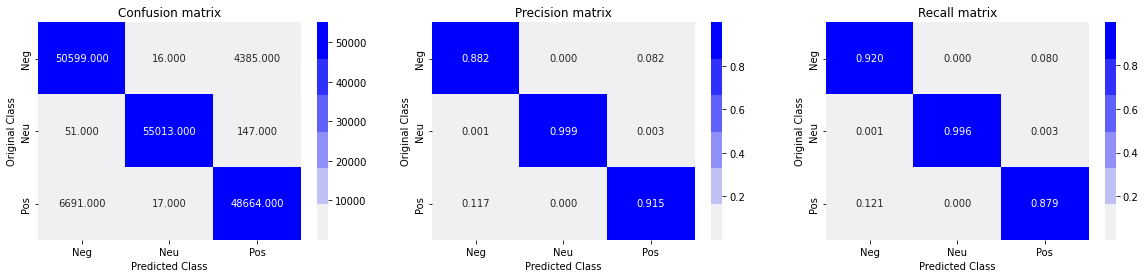

In [28]:
# For neutral class model is performing pretty well
plot_confusion_matrix(y_data,p)

In [21]:
# creating two datasets of correctly classified and incorrectly classified points
incorrect_pred=pd.DataFrame(columns=['text','target'])
correct_pred=pd.DataFrame(columns=['text','target'])
for i in range(len(p)):
    if y_data[i]!=p[i]:
        incorrect_pred.loc[len(incorrect_pred.index)]=[df.clean_text.values[i],y_data[i]]
    elif y_data[i]==p[i]:
        correct_pred.loc[len(incorrect_pred.index)]=[df.clean_text.values[i],y_data[i]]


In [25]:
# getting lengths of input sentences for 3 classes for both cases correct and incorrect pedictions
neg_word_count = correct_pred[correct_pred['target']=='Neg']['text'].str.split().apply(len)
neg_word_count = neg_word_count.values

neu_word_count = correct_pred[correct_pred['target']=='Neu']['text'].str.split().apply(len)
neu_word_count = neu_word_count.values

pos_word_count = correct_pred[correct_pred['target']=='Pos']['text'].str.split().apply(len)
pos_word_count = pos_word_count.values


neg_word_count_in = incorrect_pred[incorrect_pred['target']=='Neg']['text'].str.split().apply(len)
neg_word_count_in = neg_word_count_in.values

neu_word_count_in = incorrect_pred[incorrect_pred['target']=='Neu']['text'].str.split().apply(len)
neu_word_count_in = neu_word_count_in.values

pos_word_count_in = incorrect_pred[incorrect_pred['target']=='Pos']['text'].str.split().apply(len)
pos_word_count_in = pos_word_count_in.values

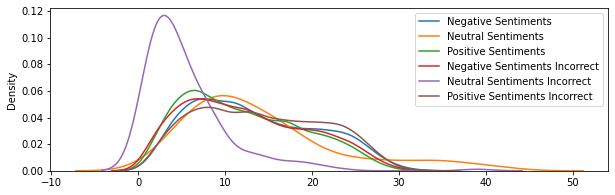

In [26]:
plt.figure(figsize=(10,3))
sns.distplot(neg_word_count, hist=False, label="Negative Sentiments")
sns.distplot(neu_word_count, hist=False, label="Neutral Sentiments")
sns.distplot(pos_word_count, hist=False, label="Positive Sentiments")

sns.distplot(neg_word_count_in, hist=False, label="Negative Sentiments Incorrect")
sns.distplot(neu_word_count_in, hist=False, label="Neutral Sentiments Incorrect")
sns.distplot(pos_word_count_in, hist=False, label="Positive Sentiments Incorrect")

plt.legend()
plt.show()

### Distribution of length of texts of correctly classified and incorrectly classified points, looks the same except for the Neutral class

In [30]:
np.mean(neg_word_count),np.mean(neg_word_count_in)

(13.43227091633466, 12.416723471938196)

In [31]:
np.mean(neu_word_count),np.mean(neu_word_count_in)

(14.147208121827411, 5.52020202020202)

In [32]:
np.mean(pos_word_count),np.mean(pos_word_count_in)

(12.06425293217746, 14.081395348837209)

In [57]:
# ploting word cloud for all 3 classes and both cases
from wordcloud import WordCloud, STOPWORDS
def get_cloud(data):
    comment_words = ''
    for val in data:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        tok=[]
        for i in tokens:
            if i not in STOPWORDS:
                tok.append(i)

        comment_words += " ".join(tok)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(comment_words)
    return wordcloud
def plot_cloud(x,y):
    plt.figure(figsize = (18, 18), facecolor = None)
    plt.subplot(1,2,1)
    plt.imshow(x)
    plt.title('X')
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title('Y')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [47]:
neg_correct=get_cloud(correct_pred.loc[correct_pred.target=='Neg'].text.values)
neu_correct=get_cloud(correct_pred.loc[correct_pred.target=='Neu'].text.values)
pos_correct=get_cloud(correct_pred.loc[correct_pred.target=='Pos'].text.values)
neg_incorrect=get_cloud(incorrect_pred.loc[incorrect_pred.target=='Neg'].text.values)
neu_incorrect=get_cloud(incorrect_pred.loc[incorrect_pred.target=='Neu'].text.values)
pos_incorrect=get_cloud(incorrect_pred.loc[incorrect_pred.target=='Pos'].text.values)

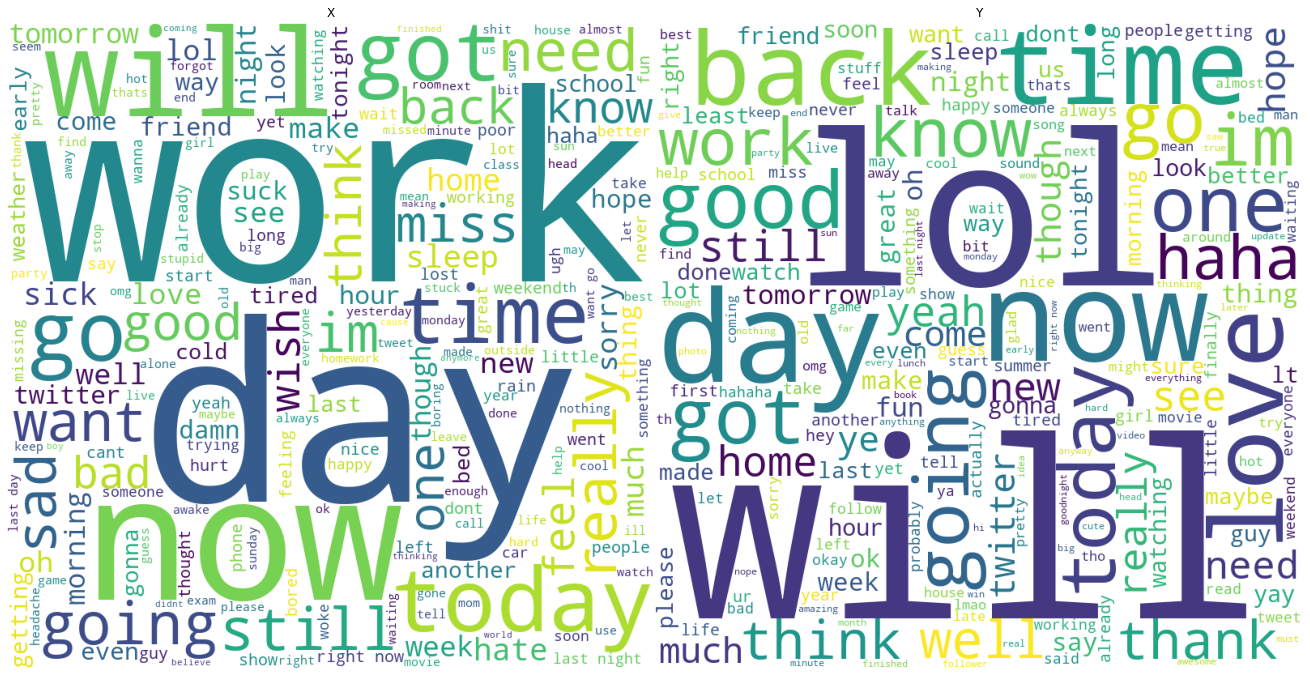

In [58]:
plot_cloud(neg_correct,neg_incorrect)


#### Correctly classified points have got words like,bad sad,feel,hate,cant,tired,end etc while incorrectly classified points have got words like home,good,love,haha,lol etc.
### I think these are the words which are common with positive points hence model is making mistakes and classifying them as positive, error in data labeling

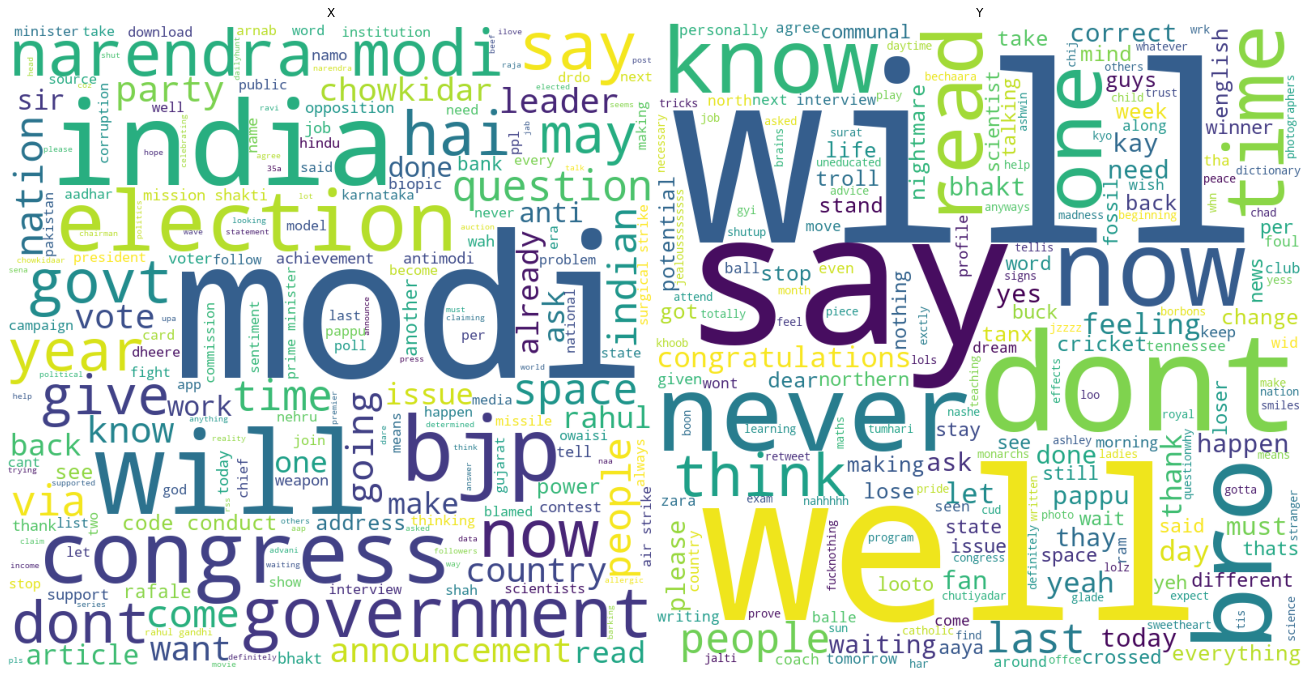

In [59]:
plot_cloud(neu_correct,neu_incorrect)


#### Majority of correctly classified points have nouns while incorrect ones have actions, since we dont have much of a missclassification in case of neutral class we are not that worried about this class

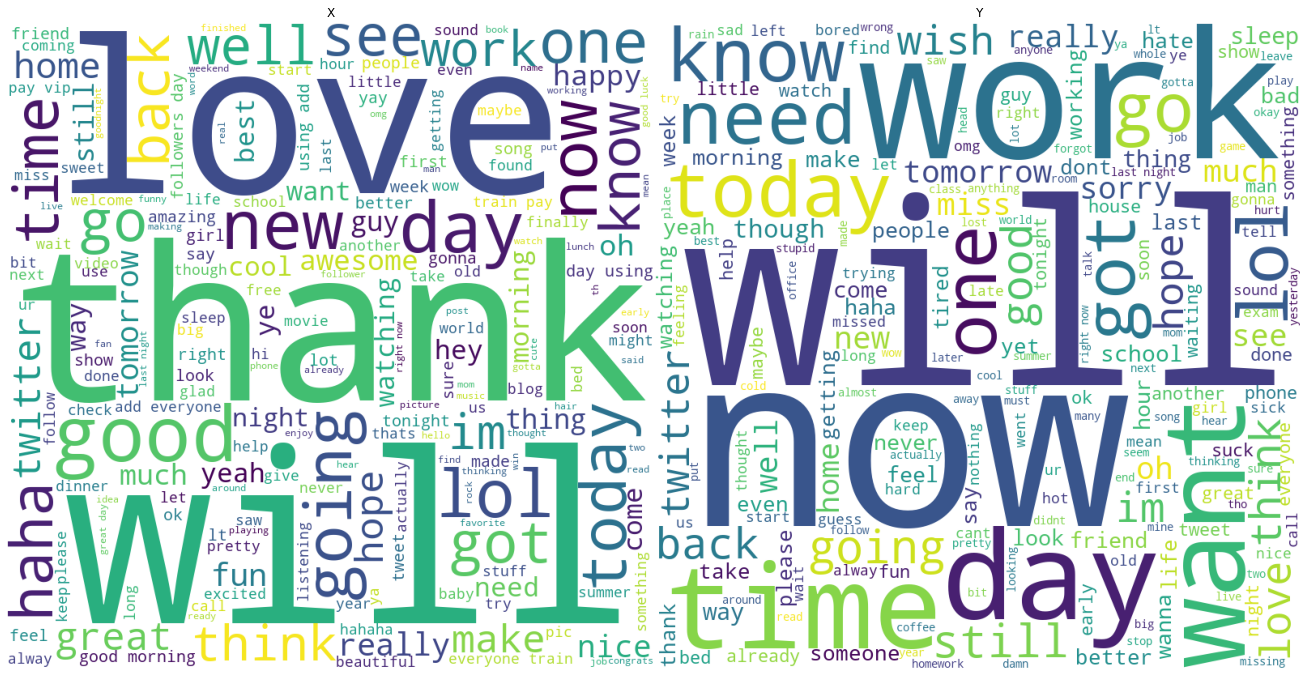

In [60]:
plot_cloud(pos_correct,pos_incorrect)


### We can clearly see the difference in words, incorrect points has more words which looks neutral at first but model classified them as negative in majority of the cases, overall looks like there is slight error in data labeling